## NLP and Random Forest Classifier to Identify Class of Genetic Mutation from Clinical Text for Precision Medicine

The data is from Kaggle Competition:
https://www.kaggle.com/c/msk-redefining-cancer-treatment/data

In [47]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import nltk
nltk.download()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [7]:
train_variants = pd.read_csv("data/training_variants")
test_variants = pd.read_csv("data/test_variants")
train_text = pd.read_csv("data/training_text", sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
test_text = pd.read_csv("data/test_text", sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
print("Train Variant".ljust(15), train_variants_df.shape)
print("Train Text".ljust(15), train_text_df.shape)
print("Test Variant".ljust(15), test_variants_df.shape)
print("Test Text".ljust(15), test_text_df.shape)

Train Variant   (3321, 4)
Train Text      (3321, 2)
Test Variant    (5668, 3)
Test Text       (5668, 2)


In [8]:
train_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [9]:
train_text.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [13]:
# unique category in each feature
print(len(train_variants_df.Gene.unique()), "unique genes")
print(len(train_variants_df.Variation.unique()), "unique variations")
print(len(train_variants_df.Class.unique()),  "classes")

264 unique genes
2996 unique variations
9 classes


### Merge text data with variants data

In [14]:
train_data = pd.merge(train_variants, train_text, how = "left", on = "ID")
train_data.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [15]:
test_data = pd.merge(test_variants, test_text, how = "left", on = "ID")
test_data.head()

,ID,Gene,Variation,Text
0,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...
1,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,PAH,L333F,Vascular endothelial growth factor receptor (V...
3,3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...


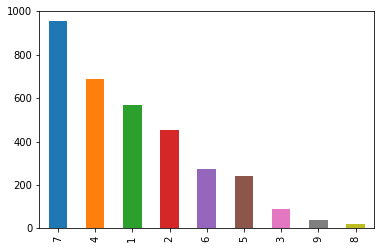

In [16]:
train_data['Class'].value_counts().plot(kind = 'bar')

In [65]:
def clean_text(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", str(text))
    text = text.lower().split()
    stop_words = {'so', 'his', 't', 'y', 'ours', 'herself', 
             'your', 'all', 'some', 'they', 'i', 'of', 'didn', 
             'them', 'when', 'will', 'that', 'its', 'because', 
             'while', 'those', 'my', 'don', 'again', 'her', 'if',
             'further', 'now', 'does', 'against', 'won', 'same', 
             'a', 'during', 'who', 'here', 'have', 'in', 'being', 
             'it', 'other', 'once', 'itself', 'hers', 'after', 're',
             'just', 'their', 'himself', 'theirs', 'whom', 'then', 'd', 
             'out', 'm', 'mustn', 'where', 'below', 'about', 'isn',
             'shouldn', 'wouldn', 'these', 'me', 'to', 'doesn', 'into',
             'the', 'until', 'she', 'am', 'under', 'how', 'yourself',
             'couldn', 'ma', 'up', 'than', 'from', 'themselves', 'yourselves',
             'off', 'above', 'yours', 'having', 'mightn', 'needn', 'on', 
             'too', 'there', 'an', 'and', 'down', 'ourselves', 'each',
             'hadn', 'ain', 'such', 've', 'did', 'be', 'or', 'aren', 'he', 
             'should', 'for', 'both', 'doing', 'this', 'through', 'do', 'had',
             'own', 'but', 'were', 'over', 'not', 'are', 'few', 'by', 
             'been', 'most', 'no', 'as', 'was', 'what', 's', 'is', 'you', 
             'shan', 'between', 'wasn', 'has', 'more', 'him', 'nor',
             'can', 'why', 'any', 'at', 'myself', 'very', 'with', 'we', 
             'which', 'hasn', 'weren', 'haven', 'our', 'll', 'only',
             'o', 'before','1','2','p','expression','mutants','cells','cancer',
             'binding','protein','activity','cbl','patient','c-cbl','fig',
             'stability','effect','samples','mutations','cell','cases','evidence',
             'gene','demonstrated','recent','frequent','acquired','ret','introduction',
             ' abstract', 'mechanism','oncogenic','novel','found','many'}
    
    # stop words from nltk library
    stop_words_nltk = set(stopwords.words('english'))
    
    text = [w for w in text if not w in stop_words]  
    text = [w for w in text if not w in stop_words_nltk]
    text = " ".join(text)
    text = text.replace("."," ").replace(","," ")
    
    
    return(text)

In [66]:
train_clean = []
for txt in train_data['Text']:
    new_text = clean_text(txt)
    train_clean.append(new_text)
train_data['cleaned_text'] = train_clean


In [57]:
test_clean = []
for txt_test in test_data['Text']:
    new_text_test = clean_text(txt_test)
    test_clean.append(new_text_test)
test_data['cleaned_text'] = test_clean

Text(0.5,1,'Top Twenty Counts of Most-Common Words Among Text')

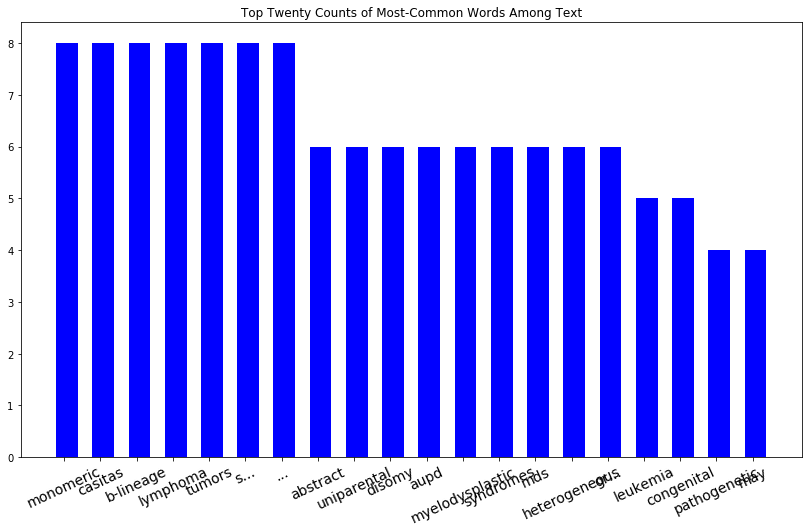

In [67]:
tops = Counter(str(train_data['cleaned_text']).split()).most_common()[:20]
labs, vals = zip(*tops)
idx = np.arange(len(labs))
wid=0.6
fig, ax=plt.subplots(1,1,figsize=(14,8))
ax=plt.bar(idx, vals, wid, color='b')
ax=plt.xticks(idx - wid/8, labs, rotation=25, size=14)
plt.title('Top Twenty Counts of Most-Common Words Among Text')

TF-IDF score represents the relative importance of a term in the document and the entire corpus. TF-IDF score is composed by two terms: the first computes the normalized Term Frequency (TF), the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

TF = (Number of times term t appears in a document) / (Total number of terms in the document)
IDF = log_e(Total number of documents / Number of documents with term t in it)

In [81]:
tfidf = TfidfVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)    

tfidf_train = tfidf.fit_transform(train_data['cleaned_text'])

In [133]:
tfidf_test = tfidf.fit_transform(test_data['cleaned_text'])

In [105]:
tfidf_train

<3321x226552 sparse matrix of type '<class 'numpy.float64'>'
	with 5420753 stored elements in Compressed Sparse Row format>

In [80]:
len(tfidf.get_feature_names())

226552

In [82]:
Y = train_data['Class'].values.ravel()
X = tfidf_train
x_train, x_val, y_train, y_val\
    = train_test_split(X, Y, test_size=0.25, random_state=1)

In [98]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc

In [84]:
clf = RandomForestClassifier(random_state = 5)
clf_param_grid = { 
    'n_estimators': np.arange(100,200,50),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(4,8,2),
    'min_samples_leaf': np.arange(2,8,2),
    'min_samples_split' : np.arange(6,12,3) 
}

cv_rf = GridSearchCV(estimator=clf, param_grid=clf_param_grid, cv= 10)
cv_rf.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=5, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([100, 150]), 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': array([4, 6]), 'min_samples_leaf': array([2, 4, 6]), 'min_samples_split': array([6, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [85]:
cv_rf.best_params_

{'max_depth': 6,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 150}

In [86]:
rf_opt = RandomForestClassifier(random_state = 5, max_depth = 6, max_features = 'auto', min_samples_leaf = 2, min_samples_split = 6, n_estimators = 150)
rf_opt.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=5, verbose=0, warm_start=False)

In [114]:
from sklearn.metrics import precision_recall_fscore_support
y_pred = rf_opt.predict(x_val)
#predictions = rf_opt.predict_proba(x_val)

precision_recall_fscore_support(y_val, y_pred, average='macro')


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.4936707877062598, 0.2810597214359059, 0.28408351139961663, None)

The result of the model showed precision of approaximately 0.5. 